# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

**Note**: this notebook requires https://github.com/huggingface/diffusers/pull/2080 (to be merged today)

In [1]:
from diffusers import UNet2DModel

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [7]:
from types import SimpleNamespace

In [8]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [9]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [10]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [11]:
dt = dls.train
xb,yb = next(iter(dt))

In [12]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572,
        315, 295, 567, 706, 749, 876,  73, 111, 899, 213, 541])

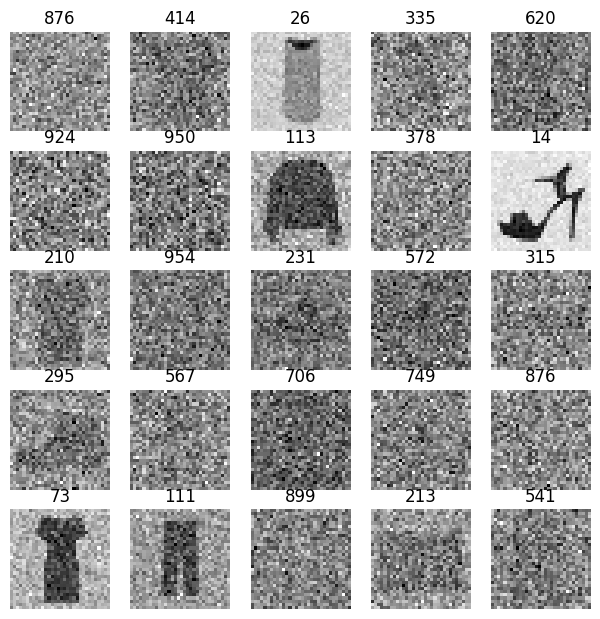

In [13]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Sampling

Using labels.

In [14]:
@torch.no_grad()
def sample(model, sz, labels):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    labels = labels.to(ps.device)
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch, labels))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

## W&B Callback

In [15]:
import wandb

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, entity='pcuenq', project='fastdiffusion', tags=['class_cond'], **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): wandb.init(entity=self.entity, project=self.project, tags=self.tags, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        if d["train"] == "train":
#         if self.train:
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            wandb.log({'samples':self.sample_figure(learn)})
        print(d)

        
    def sample_figure(self, learn):
        torch.manual_seed(0)   # Is this necessary?
        with torch.no_grad():
            # Using 32 because of padding
            samples = sample(learn.model, (16, 1, 32, 32), torch.randint(10, (16,)))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})

## Training

I modified `UNet2DModel` to accept class conditioning instead of using `UNet2DConditionModel`. The problem with `UNet2DConditionModel` is that it assumes we'll be using text conditioning too, and requires that we send `encoder_hidden_states` to the `forward` method. In addition to being inconvenient, memory consumption is higher because all the cross-attention blocks that are created by default. Batch size has to be decreased (512 -> 48) and training time increases a lot.

Another option is to specify the down/up block types when creating the UNet as `("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D")` instead of using the default cross-attention configuration `("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D")`. However, the mid block will still be `UNetMidBlock2DCrossAttn` by default.

In [16]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [17]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

We update our collate function to include the labels that will be used for conditioning.

In [18]:
(xl, yl)

('image', 'label')

In [19]:
def collate_ddpm_cond(b):
    (xt,t),ε = noisify(default_collate(b)[xl],alphabar)
    labels = default_collate(b)[yl]
    return (xt,t,labels),ε
def dl_ddpm(ds, nw=8): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm_cond, num_workers=nw)

In [20]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

`class_embed_type = "timestep"` means we apply the same embedding to "classes" as we do to timesteps. Then both embeddings are just summed together.

In [22]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'Class conditioning: modified UNet'})
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8,
             class_embed_type="timestep")
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

wandb: Currently logged in as: pcuenq. Use `wandb login --relogin` to force relogin


{'loss': '0.202', 'epoch': 0, 'train': 'train'}
{'loss': '0.042', 'epoch': 0, 'train': 'eval'}
{'loss': '0.036', 'epoch': 1, 'train': 'train'}
{'loss': '0.033', 'epoch': 1, 'train': 'eval'}
{'loss': '0.031', 'epoch': 2, 'train': 'train'}
{'loss': '0.030', 'epoch': 2, 'train': 'eval'}
{'loss': '0.029', 'epoch': 3, 'train': 'train'}
{'loss': '0.032', 'epoch': 3, 'train': 'eval'}
{'loss': '0.028', 'epoch': 4, 'train': 'train'}
{'loss': '0.027', 'epoch': 4, 'train': 'eval'}
{'loss': '0.026', 'epoch': 5, 'train': 'train'}
{'loss': '0.027', 'epoch': 5, 'train': 'eval'}
{'loss': '0.025', 'epoch': 6, 'train': 'train'}
{'loss': '0.032', 'epoch': 6, 'train': 'eval'}
{'loss': '0.025', 'epoch': 7, 'train': 'train'}
{'loss': '0.026', 'epoch': 7, 'train': 'eval'}
{'loss': '0.024', 'epoch': 8, 'train': 'train'}
{'loss': '0.026', 'epoch': 8, 'train': 'eval'}
{'loss': '0.023', 'epoch': 9, 'train': 'train'}
{'loss': '0.028', 'epoch': 9, 'train': 'eval'}
{'loss': '0.023', 'epoch': 10, 'train': 'train'}
{

loss,█▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▄▂▂▄▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.03297
train_loss,0.014
val_loss,0.025


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

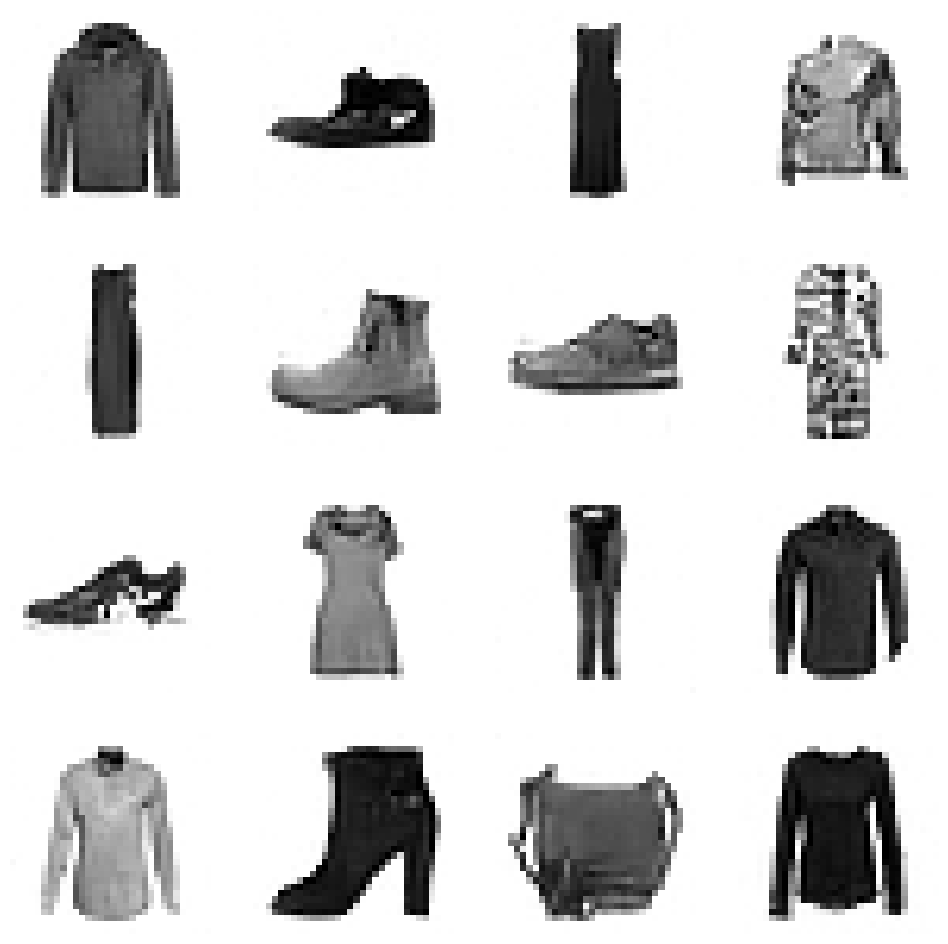

In [23]:
learn.fit(epochs)

In [24]:
mdl_path = Path('models')

In [25]:
torch.save(learn.model, mdl_path/'fashion_classcond_modified_unet.pkl')

In [26]:
model = torch.load(mdl_path/'fashion_classcond_modified_unet.pkl').cuda()

In [27]:
torch.manual_seed(0)
samples = sample(model, (16, 1, 32, 32), torch.tensor([2]*16))

In [28]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.0438), tensor(1.3548))

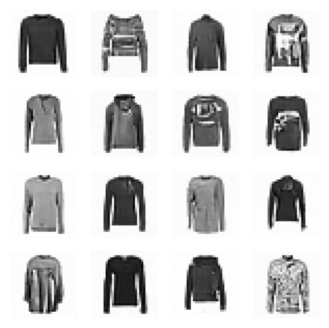

In [29]:
show_images(s, imsize=1)

In [31]:
n_samples = 512

In [33]:
%%time
samples = sample(model, (n_samples, 1, 32, 32), torch.randint(10, (n_samples,)))

CPU times: user 2min, sys: 385 ms, total: 2min 1s
Wall time: 2min


In [34]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.0822), tensor(1.3951))

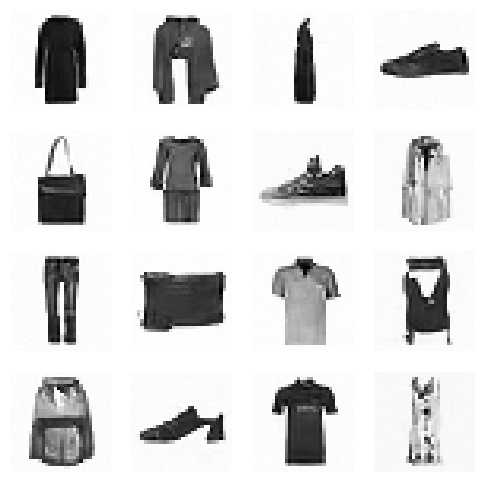

In [35]:
show_images(s[:16], imsize=1.5)

In [36]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [37]:
from miniai.fid import ImageEval

In [38]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [39]:
ie.fid(s)

9.4517822265625

In [40]:
s.min(),s.max()

(tensor(-1.0822), tensor(1.3951))

In [41]:
ie.fid(xb*2)

7.6544189453125